# Cleaning

## tldr

1. Loaded new csv with all stations AND the 2024-2025 data
2. Added time related features to help the model learn
3. Removed the stations with records below 26000 leaving 63 stations.(see other notebook for their distribution across France)
4. Created keras.sequential model as it will deal with any gaps in the time data well and learn well from the other features.
5. Trained the basic model with 30 epochs. (1.3 degrees)
6. Plotted the errors and loss. 
7. Compared to baseline (1.6 degrees.)
8. PLotted MAE and loss and although training is improving the validation is noisy so Work to be done.
9. Added some summary plots at the bottom for reference.

10. Suggested steps: Train for longer, add layers (Dropout?), reassess the time related features.

## Imports


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input
import pandas as pd

## Load Data

In [3]:
#Load new cleaned csv

df = pd.read_csv("../raw_data/all_clean_weather.csv", parse_dates=["DATE"])
df.sort_values(by=["NOM_USUEL", "DATE"], inplace=True)
df.reset_index(drop=True, inplace=True)

## Add Time Based Features

In [4]:

# Time-based features
df['day_of_year'] = df['DATE'].dt.dayofyear
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year
df['weekday'] = df['DATE'].dt.weekday

# Group by station for lagging
df_grouped = df.groupby("NOM_USUEL")

# Lag features
df['TM_lag1'] = df_grouped['TM'].shift(1)
df['TM_lag365'] = df_grouped['TM'].shift(365)

# Rolling averages (7 and 30 days)
df['TM_roll7'] = df_grouped['TM'].rolling(7).mean().reset_index(level=0, drop=True)
df['TM_roll30'] = df_grouped['TM'].rolling(30).mean().reset_index(level=0, drop=True)

df['RR_roll7'] = df_grouped['RR'].rolling(7).mean().reset_index(level=0, drop=True)
df['FFM_roll7'] = df_grouped['FFM'].rolling(7).mean().reset_index(level=0, drop=True)

# Drop rows with NaNs from shifting/rolling
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## Select stations with enough records


In [5]:
station_counts = df.groupby('NOM_USUEL')['DATE'].nunique()
top_stations = station_counts[station_counts >= 26000].index
df_top = df[df['NOM_USUEL'].isin(top_stations)].copy()
df_top

,NOM_USUEL,LAT,LON,DATE,RR,TN,TX,TM,FFM,DEP,day_of_year,month,year,weekday,TM_lag1,TM_lag365,TM_roll7,TM_roll30,RR_roll7,FFM_roll7
1821,ABBEVILLE,50.1360,1.834,1951-01-01,0.2,0.6,4.6,2.9,6.4,80,1,1,1951,0,-2.7,-0.5,-3.085714,-0.083333,0.585714,3.628571
1822,ABBEVILLE,50.1360,1.834,1951-01-02,3.4,0.9,4.0,2.7,4.9,80,2,1,1951,1,2.9,5.3,-2.342857,-0.080000,0.814286,3.900000
1823,ABBEVILLE,50.1360,1.834,1951-01-03,2.0,0.1,4.7,2.4,4.5,80,3,1,1951,2,2.7,9.7,-1.828571,-0.033333,0.885714,4.042857
1824,ABBEVILLE,50.1360,1.834,1951-01-04,4.1,0.0,8.5,2.9,4.3,80,4,1,1951,3,2.4,8.9,-1.071429,0.106667,1.471429,4.128571
1825,ABBEVILLE,50.1360,1.834,1951-01-05,1.8,3.7,10.7,8.8,6.8,80,5,1,1951,4,2.9,8.1,1.314286,0.390000,1.728571,4.828571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9598712,VILLACOUBLAY,48.7725,2.204,2025-03-30,0.0,3.8,16.0,10.3,4.3,78,89,3,2025,6,8.8,7.8,9.542857,8.496667,0.628571,3.485714
9598713,VILLACOUBLAY,48.7725,2.204,2025-03-31,0.0,3.7,14.6,9.9,4.3,78,90,3,2025,0,10.3,9.9,9.400000,8.706667,0.628571,3.785714
9598714,VILLACOUBLAY,48.7725,2.204,2025-04-01,0.0,6.0,14.1,10.0,7.8,78,91,4,2025,1,9.9,9.1,9.442857,8.866667,0.628571,4.357143
9598715,VILLACOUBLAY,48.7725,2.204,2025-04-02,0.0,6.4,16.5,11.6,5.7,78,92,4,2025,2,10.0,10.1,9.714286,9.060000,0.600000,4.700000


In [6]:
new_station_list = pd.DataFrame(df_top["NOM_USUEL"].unique())
new_station_list

,0
0,ABBEVILLE
1,AGEN-LA GARENNE
2,AJACCIO
3,ALENCON
4,AMBERIEU
...,...
65,TOULON
66,TOULOUSE-BLAGNAC
67,TRAPPES
68,VICHY-CHARMEIL


In [7]:
print(f"Original dataset shape {df.shape}")
print(f"New dataset shape {df_top.shape}")

Original dataset shape (9778545, 20)
New dataset shape (1889415, 20)


# MODEL
## Define Input Features and Targets


In [8]:
# Define target
target = "TM"

# Select features
feature_cols = [
    'day_of_year', 'month', 'year', 'weekday',
    'TM_lag1', 'TM_lag365', 'TM_roll7', 'TM_roll30',
    'RR', 'FFM', 'NOM_USUEL'
]
# 1. One-hot encode NOM_USUEL
X_encoded = pd.get_dummies(df_top[feature_cols], columns=['NOM_USUEL'])

X = df_top[feature_cols]
y = df_top['TM']

## Column Transformer and Scalers


In [9]:
# Define column groups
numeric_cols = [
    'day_of_year', 'month', 'year', 'weekday',
    'TM_lag1', 'TM_lag365', 'TM_roll7', 'TM_roll30',
    'RR', 'FFM'
]
categorical_cols = ['NOM_USUEL']

# Create the preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit-transform the full dataset
X_processed = preprocessor.fit_transform(X)

# Save encoder input structure for reuse later
ohe = preprocessor.named_transformers_['cat']
encoded_station_names = ohe.get_feature_names_out(['NOM_USUEL'])

In [10]:
print("Transformed X shape:", X_processed.shape)

Transformed X shape: (1889415, 80)


## Train Test Split


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

## Model

In [12]:
# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Train

In [13]:
# Train
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)

Epoch 1/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 471us/step - loss: 5.9091 - mae: 1.6706 - val_loss: 3.5768 - val_mae: 1.4586
Epoch 2/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 474us/step - loss: 3.4476 - mae: 1.4321 - val_loss: 3.4157 - val_mae: 1.4270
Epoch 3/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 459us/step - loss: 3.3797 - mae: 1.4177 - val_loss: 3.3902 - val_mae: 1.4179
Epoch 4/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 458us/step - loss: 3.3532 - mae: 1.4113 - val_loss: 3.3754 - val_mae: 1.4165
Epoch 5/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 475us/step - loss: 3.3299 - mae: 1.4068 - val_loss: 3.3414 - val_mae: 1.4065
Epoch 6/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 472us/step - loss: 3.3178 - mae: 1.4032 - val_loss: 3.3161 - val_mae: 1.4020
Epoch 7/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 466us/step - loss: 3.2971 - mae: 1.3992 - val_loss: 3.3138 - val_mae: 1.3985
Epoch 8/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 453us/step - loss: 3.2896 - mae: 1.3967 - val_loss: 3.3051 - val_mae: 1.3962


## Evaluate

In [14]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}°C")

11809/11809 ━━━━━━━━━━━━━━━━━━━━ 3s 276us/step - loss: 3.2320 - mae: 1.3802
Test MAE: 1.38°C


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,069 (219.02 KB)

 Trainable params: 18,689 (73.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,380 (146.02 KB)

In [16]:
 history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 468us/step - loss: 3.1985 - mae: 1.3780 - val_loss: 3.2882 - val_mae: 1.3961
Epoch 2/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 448us/step - loss: 3.1890 - mae: 1.3760 - val_loss: 3.2687 - val_mae: 1.3948
Epoch 3/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 9s 444us/step - loss: 3.1968 - mae: 1.3770 - val_loss: 3.2399 - val_mae: 1.3849
Epoch 4/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 447us/step - loss: 3.1832 - mae: 1.3746 - val_loss: 3.2740 - val_mae: 1.3931
Epoch 5/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 9s 445us/step - loss: 3.1840 - mae: 1.3748 - val_loss: 3.2867 - val_mae: 1.3969
Epoch 6/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 9s 444us/step - loss: 3.1821 - mae: 1.3744 - val_loss: 3.2786 - val_mae: 1.3919
Epoch 7/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 10s 446us/step - loss: 3.1751 - mae: 1.3724 - val_loss: 3.2480 - val_mae: 1.3841
Epoch 8/30
21256/21256 ━━━━━━━━━━━━━━━━━━━━ 9s 445us/step - loss: 3.1673 - mae: 1.3710 - val_loss: 3.2472 - val_mae: 1.3858
Epoc

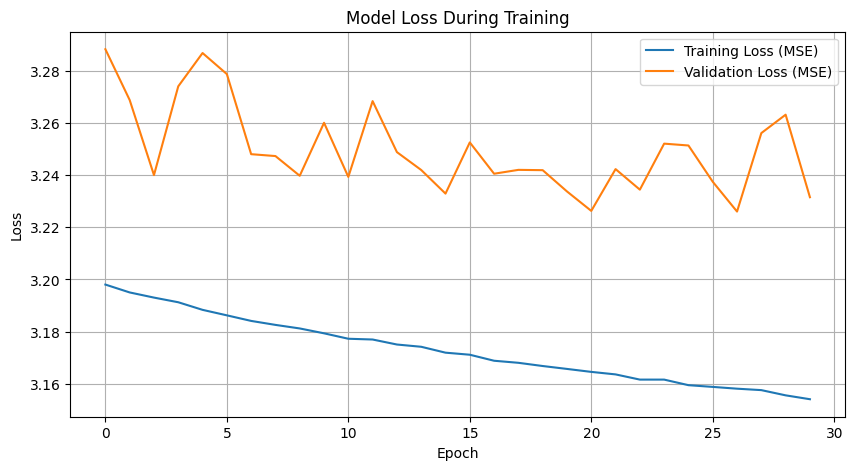

In [17]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

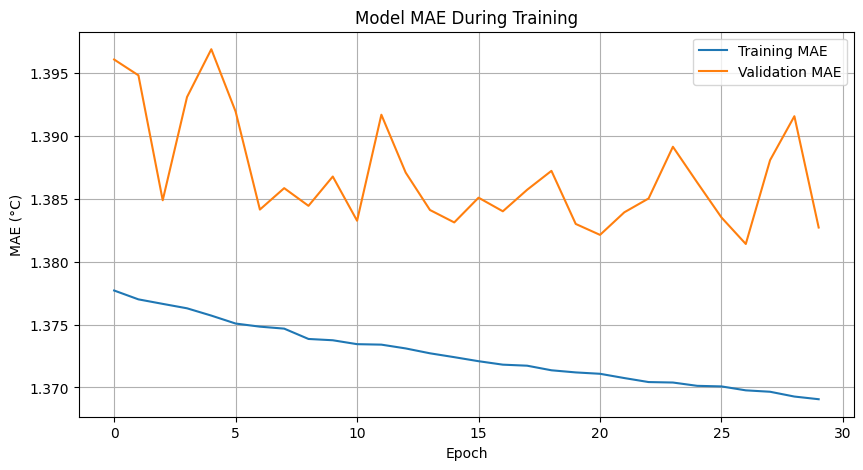

In [18]:
# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error

baseline_df = df.dropna(subset=['TM_lag1'])
mae_naive = mean_absolute_error(baseline_df['TM'], baseline_df['TM_lag1'])
print(f"🧠 Naive MAE: {mae_naive:.2f} °C")

🧠 Naive MAE: 1.61 °C


In [20]:
df_top

,NOM_USUEL,LAT,LON,DATE,RR,TN,TX,TM,FFM,DEP,day_of_year,month,year,weekday,TM_lag1,TM_lag365,TM_roll7,TM_roll30,RR_roll7,FFM_roll7
1821,ABBEVILLE,50.1360,1.834,1951-01-01,0.2,0.6,4.6,2.9,6.4,80,1,1,1951,0,-2.7,-0.5,-3.085714,-0.083333,0.585714,3.628571
1822,ABBEVILLE,50.1360,1.834,1951-01-02,3.4,0.9,4.0,2.7,4.9,80,2,1,1951,1,2.9,5.3,-2.342857,-0.080000,0.814286,3.900000
1823,ABBEVILLE,50.1360,1.834,1951-01-03,2.0,0.1,4.7,2.4,4.5,80,3,1,1951,2,2.7,9.7,-1.828571,-0.033333,0.885714,4.042857
1824,ABBEVILLE,50.1360,1.834,1951-01-04,4.1,0.0,8.5,2.9,4.3,80,4,1,1951,3,2.4,8.9,-1.071429,0.106667,1.471429,4.128571
1825,ABBEVILLE,50.1360,1.834,1951-01-05,1.8,3.7,10.7,8.8,6.8,80,5,1,1951,4,2.9,8.1,1.314286,0.390000,1.728571,4.828571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9598712,VILLACOUBLAY,48.7725,2.204,2025-03-30,0.0,3.8,16.0,10.3,4.3,78,89,3,2025,6,8.8,7.8,9.542857,8.496667,0.628571,3.485714
9598713,VILLACOUBLAY,48.7725,2.204,2025-03-31,0.0,3.7,14.6,9.9,4.3,78,90,3,2025,0,10.3,9.9,9.400000,8.706667,0.628571,3.785714
9598714,VILLACOUBLAY,48.7725,2.204,2025-04-01,0.0,6.0,14.1,10.0,7.8,78,91,4,2025,1,9.9,9.1,9.442857,8.866667,0.628571,4.357143
9598715,VILLACOUBLAY,48.7725,2.204,2025-04-02,0.0,6.4,16.5,11.6,5.7,78,92,4,2025,2,10.0,10.1,9.714286,9.060000,0.600000,4.700000


In [21]:
top_stations = pd.DataFrame(df["NOM_USUEL"].unique())
print(new_station_list)

                   0
0          ABBEVILLE
1    AGEN-LA GARENNE
2            AJACCIO
3            ALENCON
4           AMBERIEU
..               ...
65            TOULON
66  TOULOUSE-BLAGNAC
67           TRAPPES
68    VICHY-CHARMEIL
69      VILLACOUBLAY

[70 rows x 1 columns]


## PREDICT

In [22]:
def predict_temp(model, preprocessor, df, station, date_str):
    import pandas as pd

    # Parse future date
    future_date = pd.to_datetime(date_str)

    # Step 1: Build base input with time features
    input_row = {
        'day_of_year': future_date.dayofyear,
        'month': future_date.month,
        'year': future_date.year,
        'weekday': future_date.weekday(),
        'NOM_USUEL': station
    }

    # Step 2: Get most recent record for this station
    latest = df[df['NOM_USUEL'] == station].sort_values('DATE').iloc[-1]

    # Add lag + weather features
    input_row.update({
        'TM_lag1': latest['TM'],
        'TM_lag365': latest['TM_lag365'],
        'TM_roll7': latest['TM_roll7'],
        'TM_roll30': latest['TM_roll30'],
        'RR': latest['RR'],
        'FFM': latest['FFM']
    })

    # Step 3: Make into a DataFrame
    input_df = pd.DataFrame([input_row])

    # Step 4: Preprocess using your fitted transformer
    input_transformed = preprocessor.transform(input_df)

    # Step 5: Predict
    prediction = model.predict(input_transformed)

    return float(prediction[0])

In [23]:
temp = predict_temp(
    model=model,
    preprocessor=preprocessor,
    df=df,  # your full historical weather_df
    station="TOULON",
    date_str="2055-08-31"
)

print(f"🌡️ Predicted temp for LYON on 2025-06-12: {temp:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🌡️ Predicted temp for LYON on 2025-06-12: 18.58 °C


/var/folders/7v/wnbw02vs6nx272x1b_2gm2b00000gn/T/ipykernel_63811/2967095456.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(prediction[0])


## PLOTS

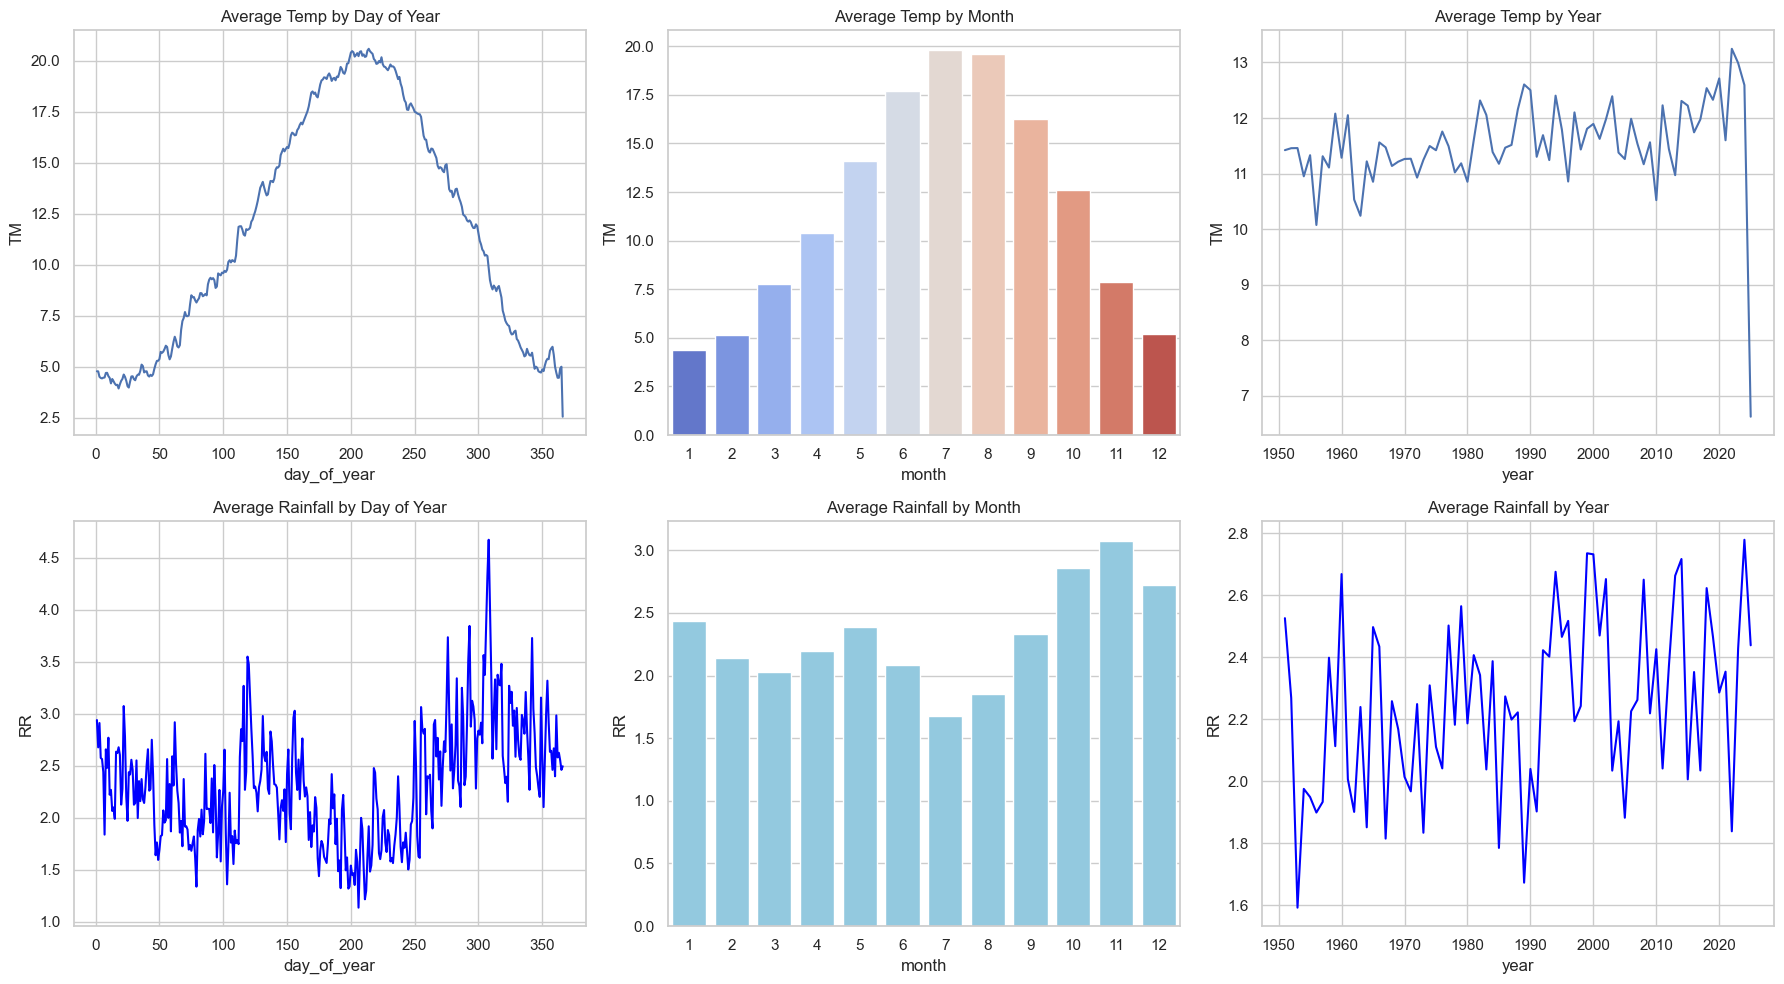

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings from seaborn/pandas
warnings.filterwarnings("ignore", category=FutureWarning)


# Grouped averages
dayofyear_df = df.groupby('day_of_year')[['TM', 'RR']].mean().reset_index()
month_df = df.groupby('month')[['TM', 'RR']].mean().reset_index()
year_df = df.groupby('year')[['TM', 'RR']].mean().reset_index()

# Seaborn theme
sns.set(style="whitegrid")

# Plot layout
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Temperature plots
sns.lineplot(data=dayofyear_df, x='day_of_year', y='TM', ax=axs[0, 0])
axs[0, 0].set_title("Average Temp by Day of Year")

sns.barplot(data=month_df, x='month', y='TM', ax=axs[0, 1], palette="coolwarm")
axs[0, 1].set_title("Average Temp by Month")

sns.lineplot(data=year_df, x='year', y='TM', ax=axs[0, 2])
axs[0, 2].set_title("Average Temp by Year")

# Rainfall plots
sns.lineplot(data=dayofyear_df, x='day_of_year', y='RR', ax=axs[1, 0], color='blue')
axs[1, 0].set_title("Average Rainfall by Day of Year")

sns.barplot(data=month_df, x='month', y='RR', ax=axs[1, 1], color='skyblue')
axs[1, 1].set_title("Average Rainfall by Month")

sns.lineplot(data=year_df, x='year', y='RR', ax=axs[1, 2], color='blue')
axs[1, 2].set_title("Average Rainfall by Year")

plt.tight_layout()
plt.show()